
# Gaussian denoiser

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from ml_physics_utils import Task, DataFrameResultHandler
from ml_physics_utils.notebook import progressbar
from ml_physics_utils.plot import qplot
import logging
logger = logging.getLogger()

## Model

In [2]:
from tramp.experiments import TeacherStudentScenario
from tramp.models import GaussianDenoiser

In [3]:
denoiser = GaussianDenoiser(N=100, prior_type="gauss_bernouilli", var_noise=0.4, rho=0.5)
print(f"denoiser = {denoiser}")

denoiser = GaussianDenoiser(
  prior=GaussBernouilliPrior(size=100,rho=0.5,mean=0,var=1),
  channel=GaussianChannel(var=0.4)
)


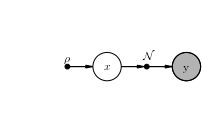

In [4]:
scenario = TeacherStudentScenario(denoiser)
scenario.setup()
scenario.student.daft()

## Experiments

In [5]:
from tramp.algos import EarlyStopping
def run_denoiser(N, prior_type, var_noise, **kwargs):
    denoiser = GaussianDenoiser(N, prior_type, var_noise, **kwargs)
    scenario = TeacherStudentScenario(denoiser)
    scenario.setup()
    scenario.infer()
    result = dict(
        mse_se=scenario.mse_se["x"], n_iter_se=scenario.n_iter_se,
        mse_ep=scenario.mse_ep["x"], n_iter_ep=scenario.n_iter_ep,
        mse=scenario.mse["x"]
    )
    return result

## Experiments

In [6]:
from ml_physics_utils import Task, DataFrameResultHandler
from ml_physics_utils.notebook import progressbar
from ml_physics_utils.plot import qplot
logger.setLevel(logging.ERROR)

csv_file = "../data/gaussian_denoiser_experiments.csv"

def run_experiments():
    result_handler = DataFrameResultHandler()
    task = Task(
        run_denoiser, 
        N=1000, prior_type="gaussian", var_noise = 10**np.linspace(-2,2,50)
    )
    with progressbar() as on_progress:
        task.run(result_handler, on_progress)
    task = Task(
        run_denoiser, 
        N=1000, prior_type="binary", var_noise = 10**np.linspace(-2,2,50), p_pos=[0.25, 0.5]
    )
    with progressbar() as on_progress:
        task.run(result_handler, on_progress)
    task = Task(
        run_denoiser, 
        N=1000, prior_type="gauss_bernouilli", var_noise = 10**np.linspace(-2,2,50), rho=[0.25, 0.5]
    )
    with progressbar() as on_progress:
        task.run(result_handler, on_progress)
    df = result_handler.get_dataframe()
    df.to_csv(csv_file, index=False)
    return df

In [7]:
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    df = run_experiments()

## Evolution of mse w/ var_noise

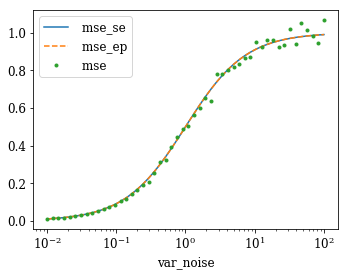

In [8]:
qplot(
    df.query("prior_type=='gaussian'"), 
    x="var_noise", y=["mse_se","mse_ep", "mse"], y_markers=["-","--", "."], y_legend=True,
    xlog=True, figsize=(5,4)
)

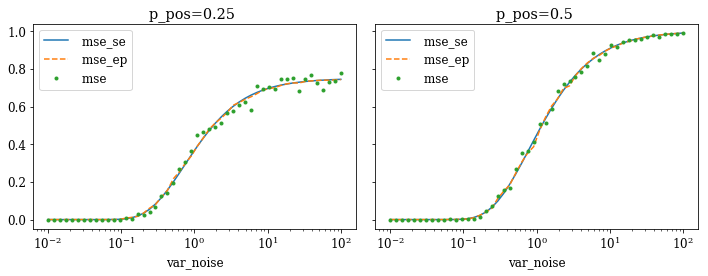

In [9]:
qplot(
    df.query("prior_type=='binary'"), 
    x="var_noise", y=["mse_se","mse_ep", "mse"], y_markers=["-","--", "."], y_legend=True, column="p_pos",
    xlog=True, figsize=(10,4)
)

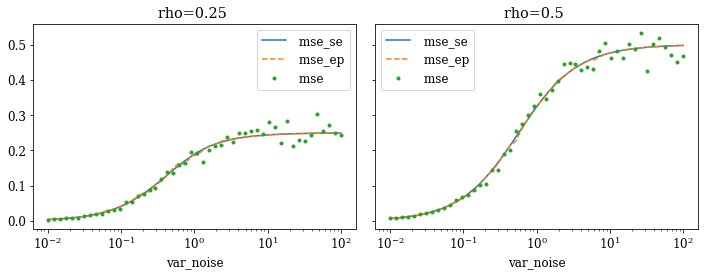

In [10]:
qplot(
    df.query("prior_type=='gauss_bernouilli'"), 
    x="var_noise", 
    y=["mse_se","mse_ep", "mse"], y_markers=["-","--", "."], y_legend=True, 
    column="rho",
    xlog=True, figsize=(10,4)
)

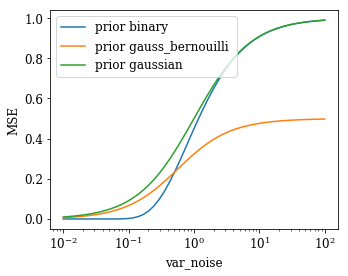

In [11]:
qplot(
    df.query("rho!=0.25 & p_pos!=0.25"), 
    x="var_noise", y="mse_se", color="prior_type", xlog=True,
    figsize=(5, 4),rename={"mse_se":"MSE", "prior_type=":"prior "}
)

## I-MMSE 

For a noisy observation $y_\gamma = x + \mathcal{N}(\gamma)$ of signal $x$, with noise variance $\gamma$, we have 

$$\frac{d}{d\gamma} I(x, y_\gamma) = \frac{1}{2} mse(x \mid y_\gamma)$$

In [12]:
def mutual_info(var_noise):
    return 0.5*np.log(1 + var_noise)
def mutual_info_prime(var_noise):
    return 0.5*var_noise/(1 + var_noise)
df["I"]=df["var_noise"].map(mutual_info)
df["2I_prime"]= 2 * df["var_noise"].map(mutual_info_prime)

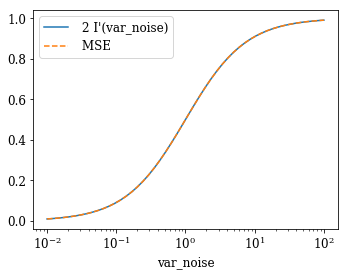

In [13]:
qplot(
    df.query("prior_type=='gaussian'"), 
    x="var_noise", y=["2I_prime","mse_se"], y_markers=["-","--"],
    xlog=True, figsize=(5, 4),y_legend=True,
    rename={"mse_se":"MSE", "2I_prime":"2 I'(var_noise)"}
)